In [1]:
import os
import sys
import pickle
from collections import Counter

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import colorsys
plt.style.use('seaborn-v0_8-white')

from scipy.stats import gaussian_kde

In [3]:
import TopoDiff

project_dir = os.path.dirname(os.path.dirname(TopoDiff.__path__[0]))
data_dir = os.path.join(project_dir, 'data', 'dataset')

# utils

In [4]:
# foo{ab} -> ab
clear_wrap = lambda x: x.split('{')[1].split('}')[0]

def max_complete_word(words, max_len=5):
    result, length = [], 0
    for word in words.split():
        if length + len(word) + len(result) > max_len:
            break
        result.append(word)
        length += len(word)
    return ' '.join(result)

def label_to_index(labels):
    labels_set = sorted(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(labels_set)}
    return np.array([label_to_index[label] for label in labels]), labels_set

def hex_to_rgb(hex_color):
    return tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))

def rgb_to_hex(rgb_color):
    return '#' + ''.join(f'{int(c * 255):02x}' for c in rgb_color)

def darken_color(color, amount=0.7):
    rgb_color = hex_to_rgb(color) if isinstance(color, str) else color
    h, l, s = colorsys.rgb_to_hls(*rgb_color)
    darkened = colorsys.hls_to_rgb(h, max(0, min(1, l * amount)), s)
    return rgb_to_hex(darkened) if isinstance(color, str) else darkened

# load data

In [5]:
label_df_path = os.path.join(data_dir, 'CATH_60.csv')
embedding_path = os.path.join(data_dir, 'CATH_60_embedding.pkl')
embedding_path_2 = os.path.join(data_dir, 'CATH_60_embedding_reproduced.pkl')

In [6]:
label_df = pd.read_csv(label_df_path)

if os.path.exists(embedding_path_2):
    print('Found reproduced embedding, using it')
    final_path = embedding_path_2
else:
    print('No reproduced embedding found, using precomputed one')
    final_path = embedding_path

with open(final_path, 'rb') as f:
    embedding = pickle.load(f)
    embed_2d = embedding['embed_2d']

Found reproduced embedding, using it


In [7]:
label_df.head()

key domain_id       CATH_ID       class_1                class_2  \
0  139lA00   139lA00   1.10.530.40  Mainly Alpha      Orthogonal Bundle   
1  16pkA01   16pkA01  3.40.50.1260    Alpha Beta  3-Layer(aba) Sandwich   
2  16pkA02   16pkA02  3.40.50.1260    Alpha Beta  3-Layer(aba) Sandwich   
3  1914A00   1914A00   3.30.720.10    Alpha Beta       2-Layer Sandwich   
4  1a04A01   1a04A01  3.40.50.2300    Alpha Beta  3-Layer(aba) Sandwich   

                                             class_3  \
0                                           Lysozyme   
1                                      Rossmann fold   
2                                      Rossmann fold   
3  Signal recognition particle alu RNA binding he...   
4                                      Rossmann fold   

                                             class_4  length  alpha_ratio  \
0                                                NaN     162     0.654321   
1         Phosphoglycerate kinase, N-terminal domain     188     0.414894   
2         Phosphoglycerate kinase, N-terminal domain     208     0.437500   
3  Signal recognition particle alu RNA binding he...     208     0.362573   
4                                                NaN     124     0.435484   

   beta_ratio  coil_ratio  gyration_radius  
0    0.092593    0.253086         1.647574  
1    0.170213    0.414894         1.555073  
2    0.163462    0.399038         1.611004  
3    0.298246    0.339181         1.649240  
4    0.225806    0.338710         1.344929

# CATH - class

In [8]:
attrib_label = 'CATH - Class'
label_index, class_text = label_to_index(label_df['class_1'])

cmap = ListedColormap([darken_color(c, 0.8) for c in sns.color_palette('Set2', n_colors=3)])

Text(0.5, 1.0, 'CATH - Class')

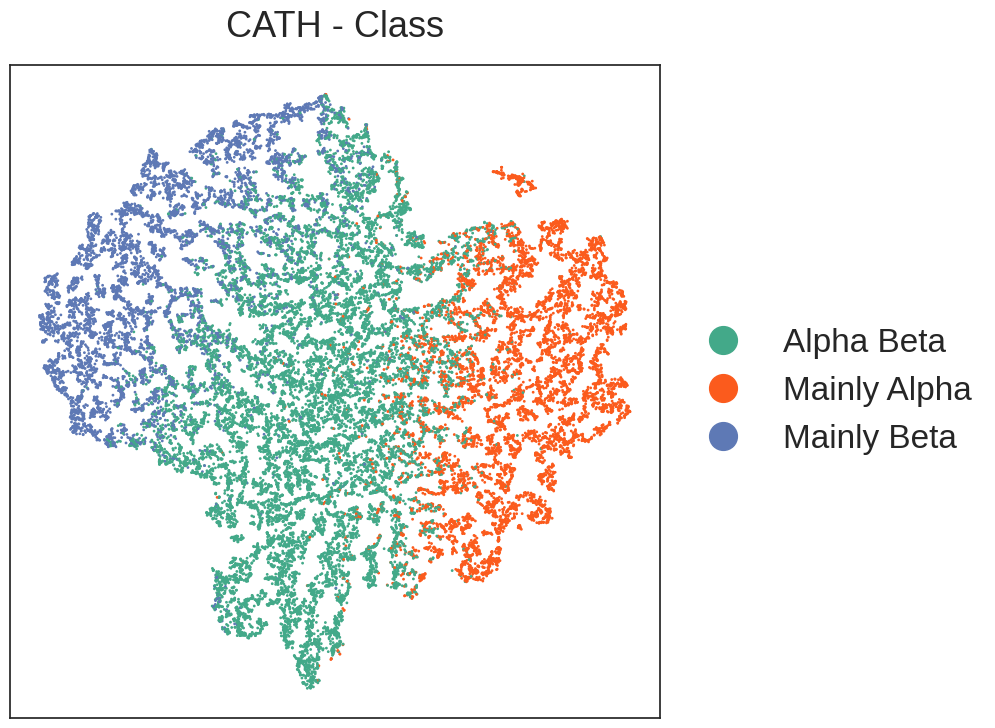

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9), subplot_kw={'aspect': 1}, squeeze=False)
fig.tight_layout(pad=8.0)

ft = 24
ft_l = 20
ft_ll = 26

scatter = ax[0, 0].scatter(embed_2d[:, 0], embed_2d[:, 1], s=1, c = label_index, cmap=cmap)  # Set1
a, b = scatter.legend_elements()
b = ['%s'% class_text[int(clear_wrap(i))] for i in b]
legend = ax[0, 0].legend(a, b, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=ft, title_fontsize=ft,
                title=None,
                handlelength=2,
                markerscale=2,
                )
for hd in legend.legend_handles:
    hd.set_markersize(20)

# remove ticks
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 0].set_title(attrib_label, fontsize=ft_ll, pad=20)

# CATH - Architecture

In [10]:
attrib_label = 'CATH - Architecture'
label_index, class_text = label_to_index(label_df['class_2'])

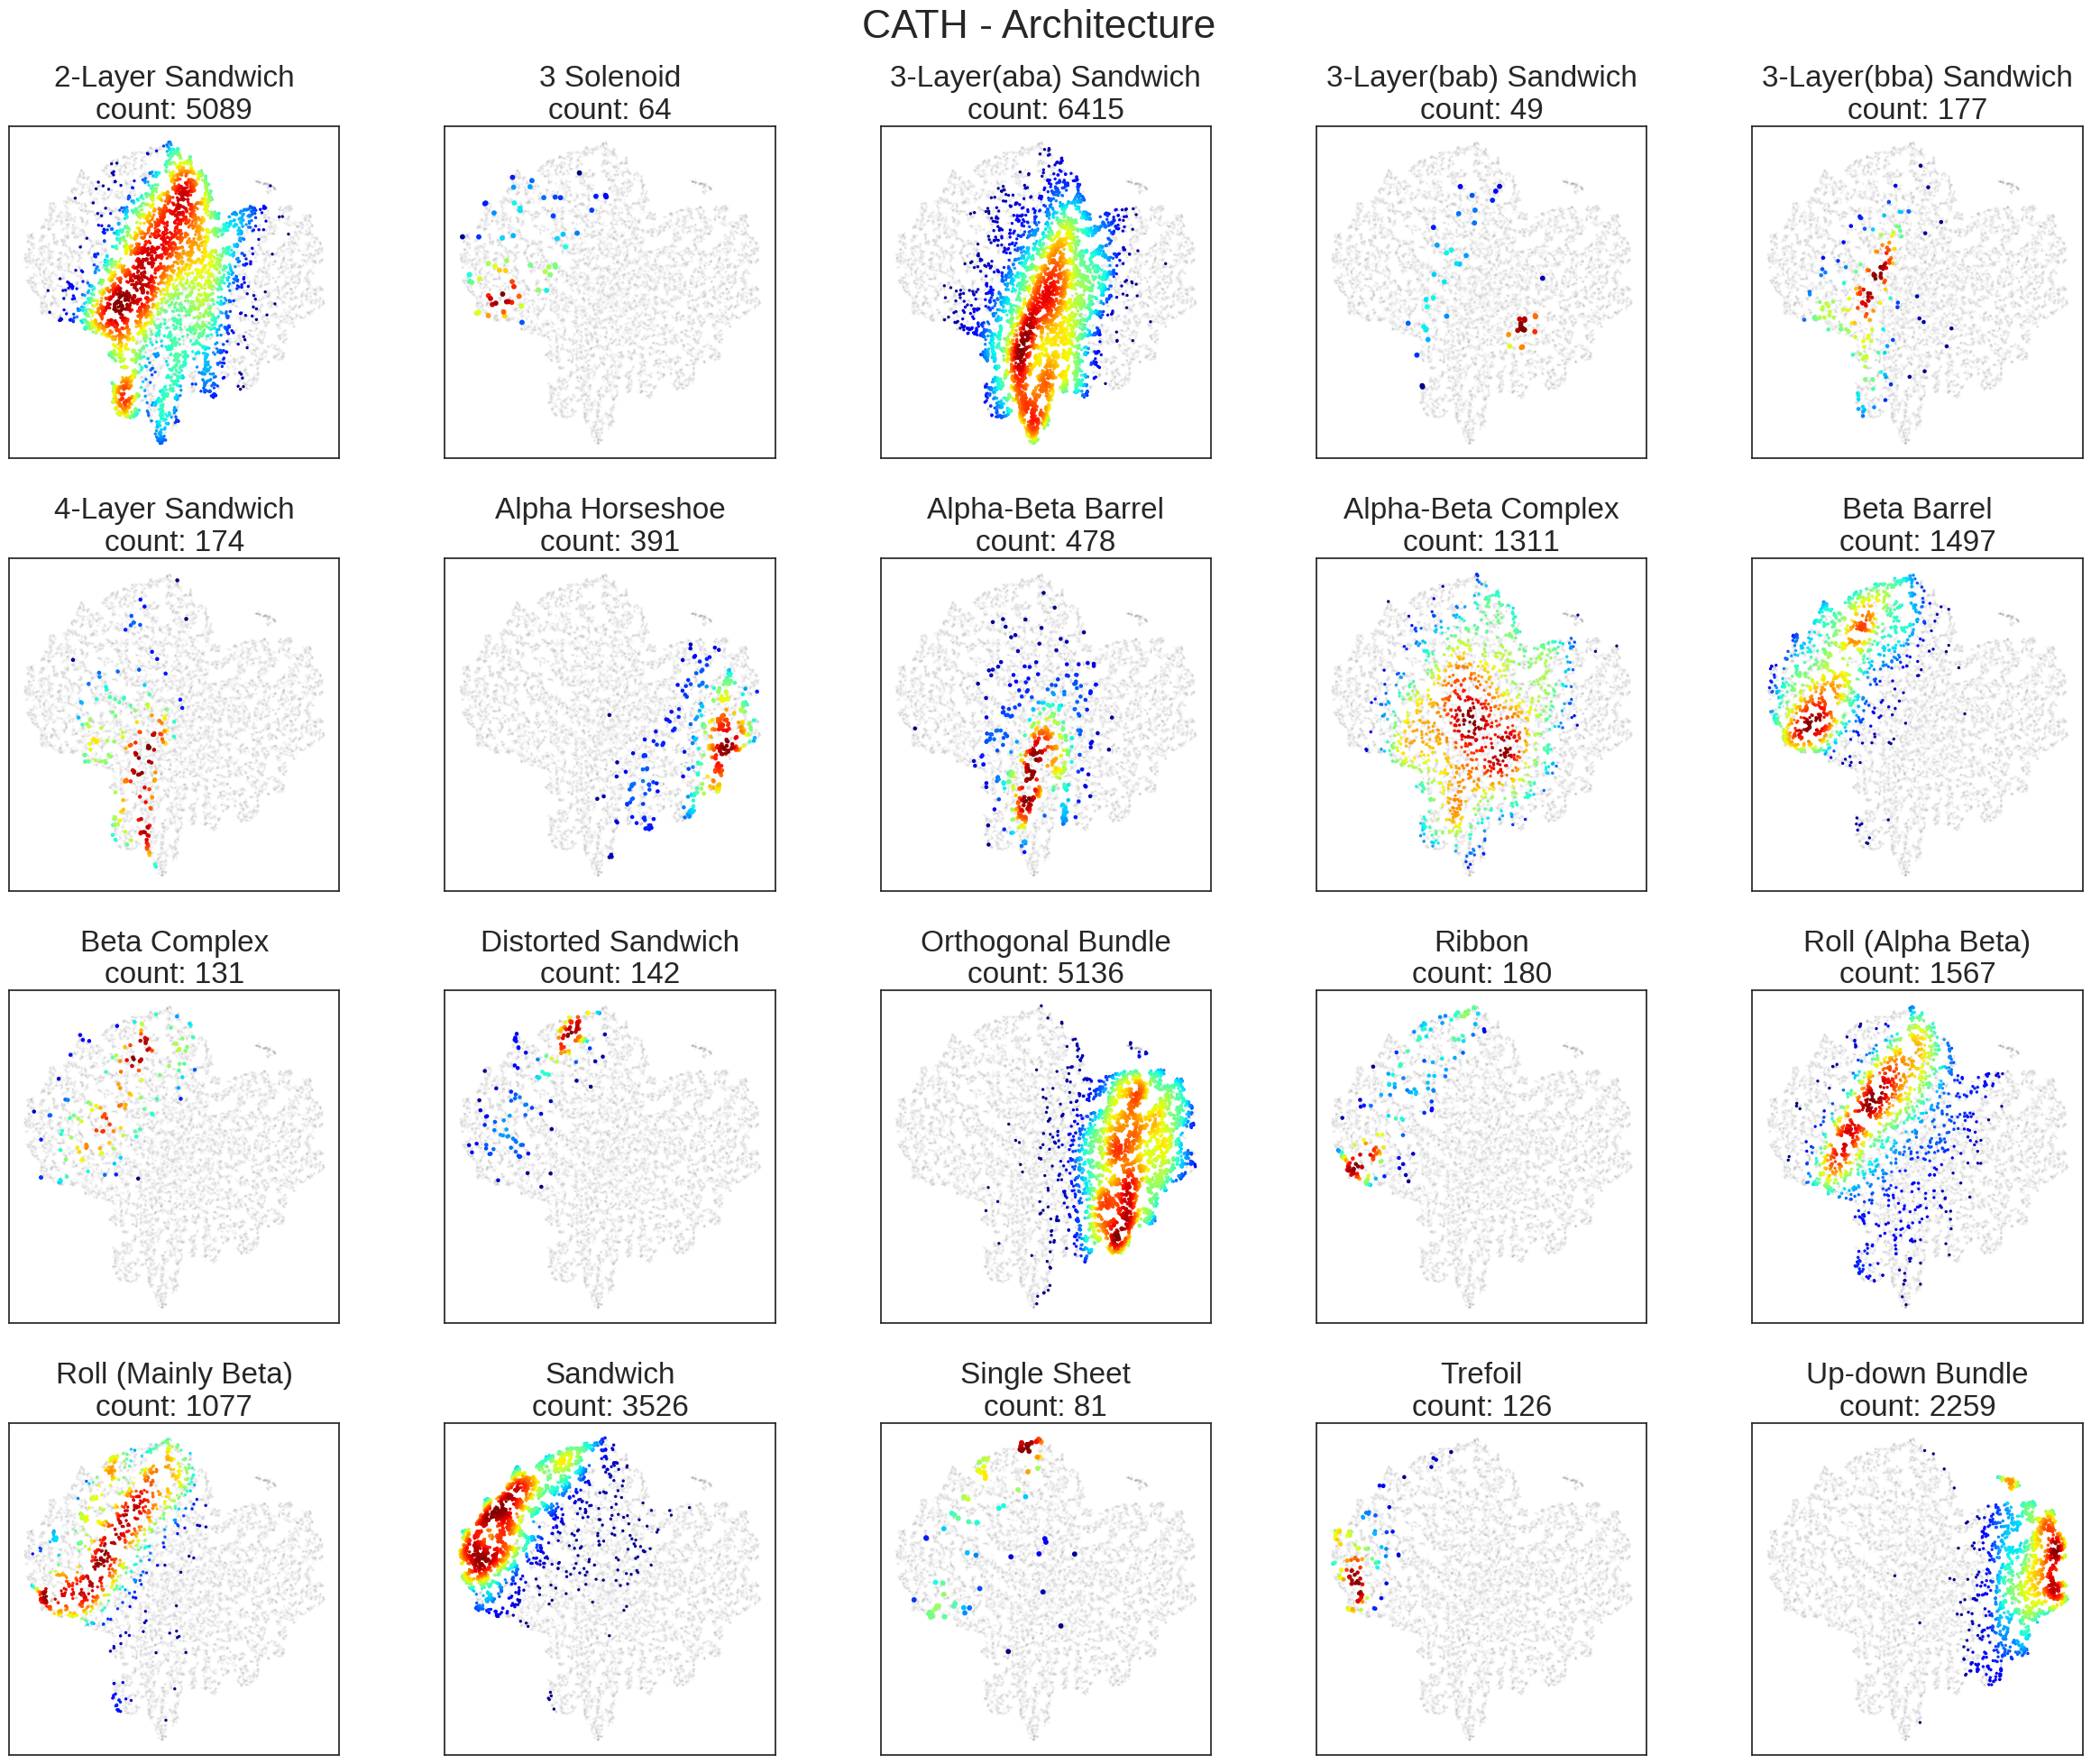

In [11]:
min_num = 40

archi_ctr = Counter(label_index)
valid_archi = [archi for archi, num in archi_ctr.most_common() if num >= min_num]
valid_archi = sorted(valid_archi)
n_architecture = len(valid_archi)

n_col = 5
n_row = int(np.ceil(n_architecture / n_col))

fig, ax = plt.subplots(n_row, n_col, figsize=(n_col * 5, n_row * 5), subplot_kw={'aspect': 1})
fig.tight_layout(pad=6.0)

ft = 15
ft_l = 24
ft_ll = 32

fig.suptitle(attrib_label, fontsize=ft_ll, y=1.02)

for i, archi_idx in enumerate(valid_archi):
    positive_mask = label_index == archi_idx

    ax[i // n_col][i % n_col].scatter(embed_2d[~positive_mask, 0], embed_2d[~positive_mask, 1], s=1, color='grey', alpha=0.02)

    xy = embed_2d[positive_mask, :]
    # https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density
    xy_T = xy.T
    z = gaussian_kde(xy_T)(xy_T)
    idx = z.argsort()
    x, y, z = xy[idx, 0], xy[idx, 1], z[idx]
    # increase the size when total number of points is small
    if len(x) < 100:
        size = 10
    elif len(x) < 500:
        size = 5
    else:
        size = 2
    ax[i // n_col][i % n_col].scatter(x, y, c=z, s=size, cmap='jet')

    ax[i // n_col][i % n_col].tick_params(axis='both', which='major', labelsize=ft)
    ax[i // n_col][i % n_col].set_title('%s\ncount: %d' % (class_text[archi_idx], archi_ctr[archi_idx]),
                                                        fontsize=ft_l)


    ax[i // n_col][i % n_col].set_xticks([])
    ax[i // n_col][i % n_col].set_yticks([])

# blank for padding
for i in range(n_architecture, n_col * n_row):
    ax[i // n_col][i % n_col].axis('off')

# CATH - Fold

In [12]:
attrib_label = 'CATH - Fold'
label_index, class_text = label_to_index(label_df['class_3'])

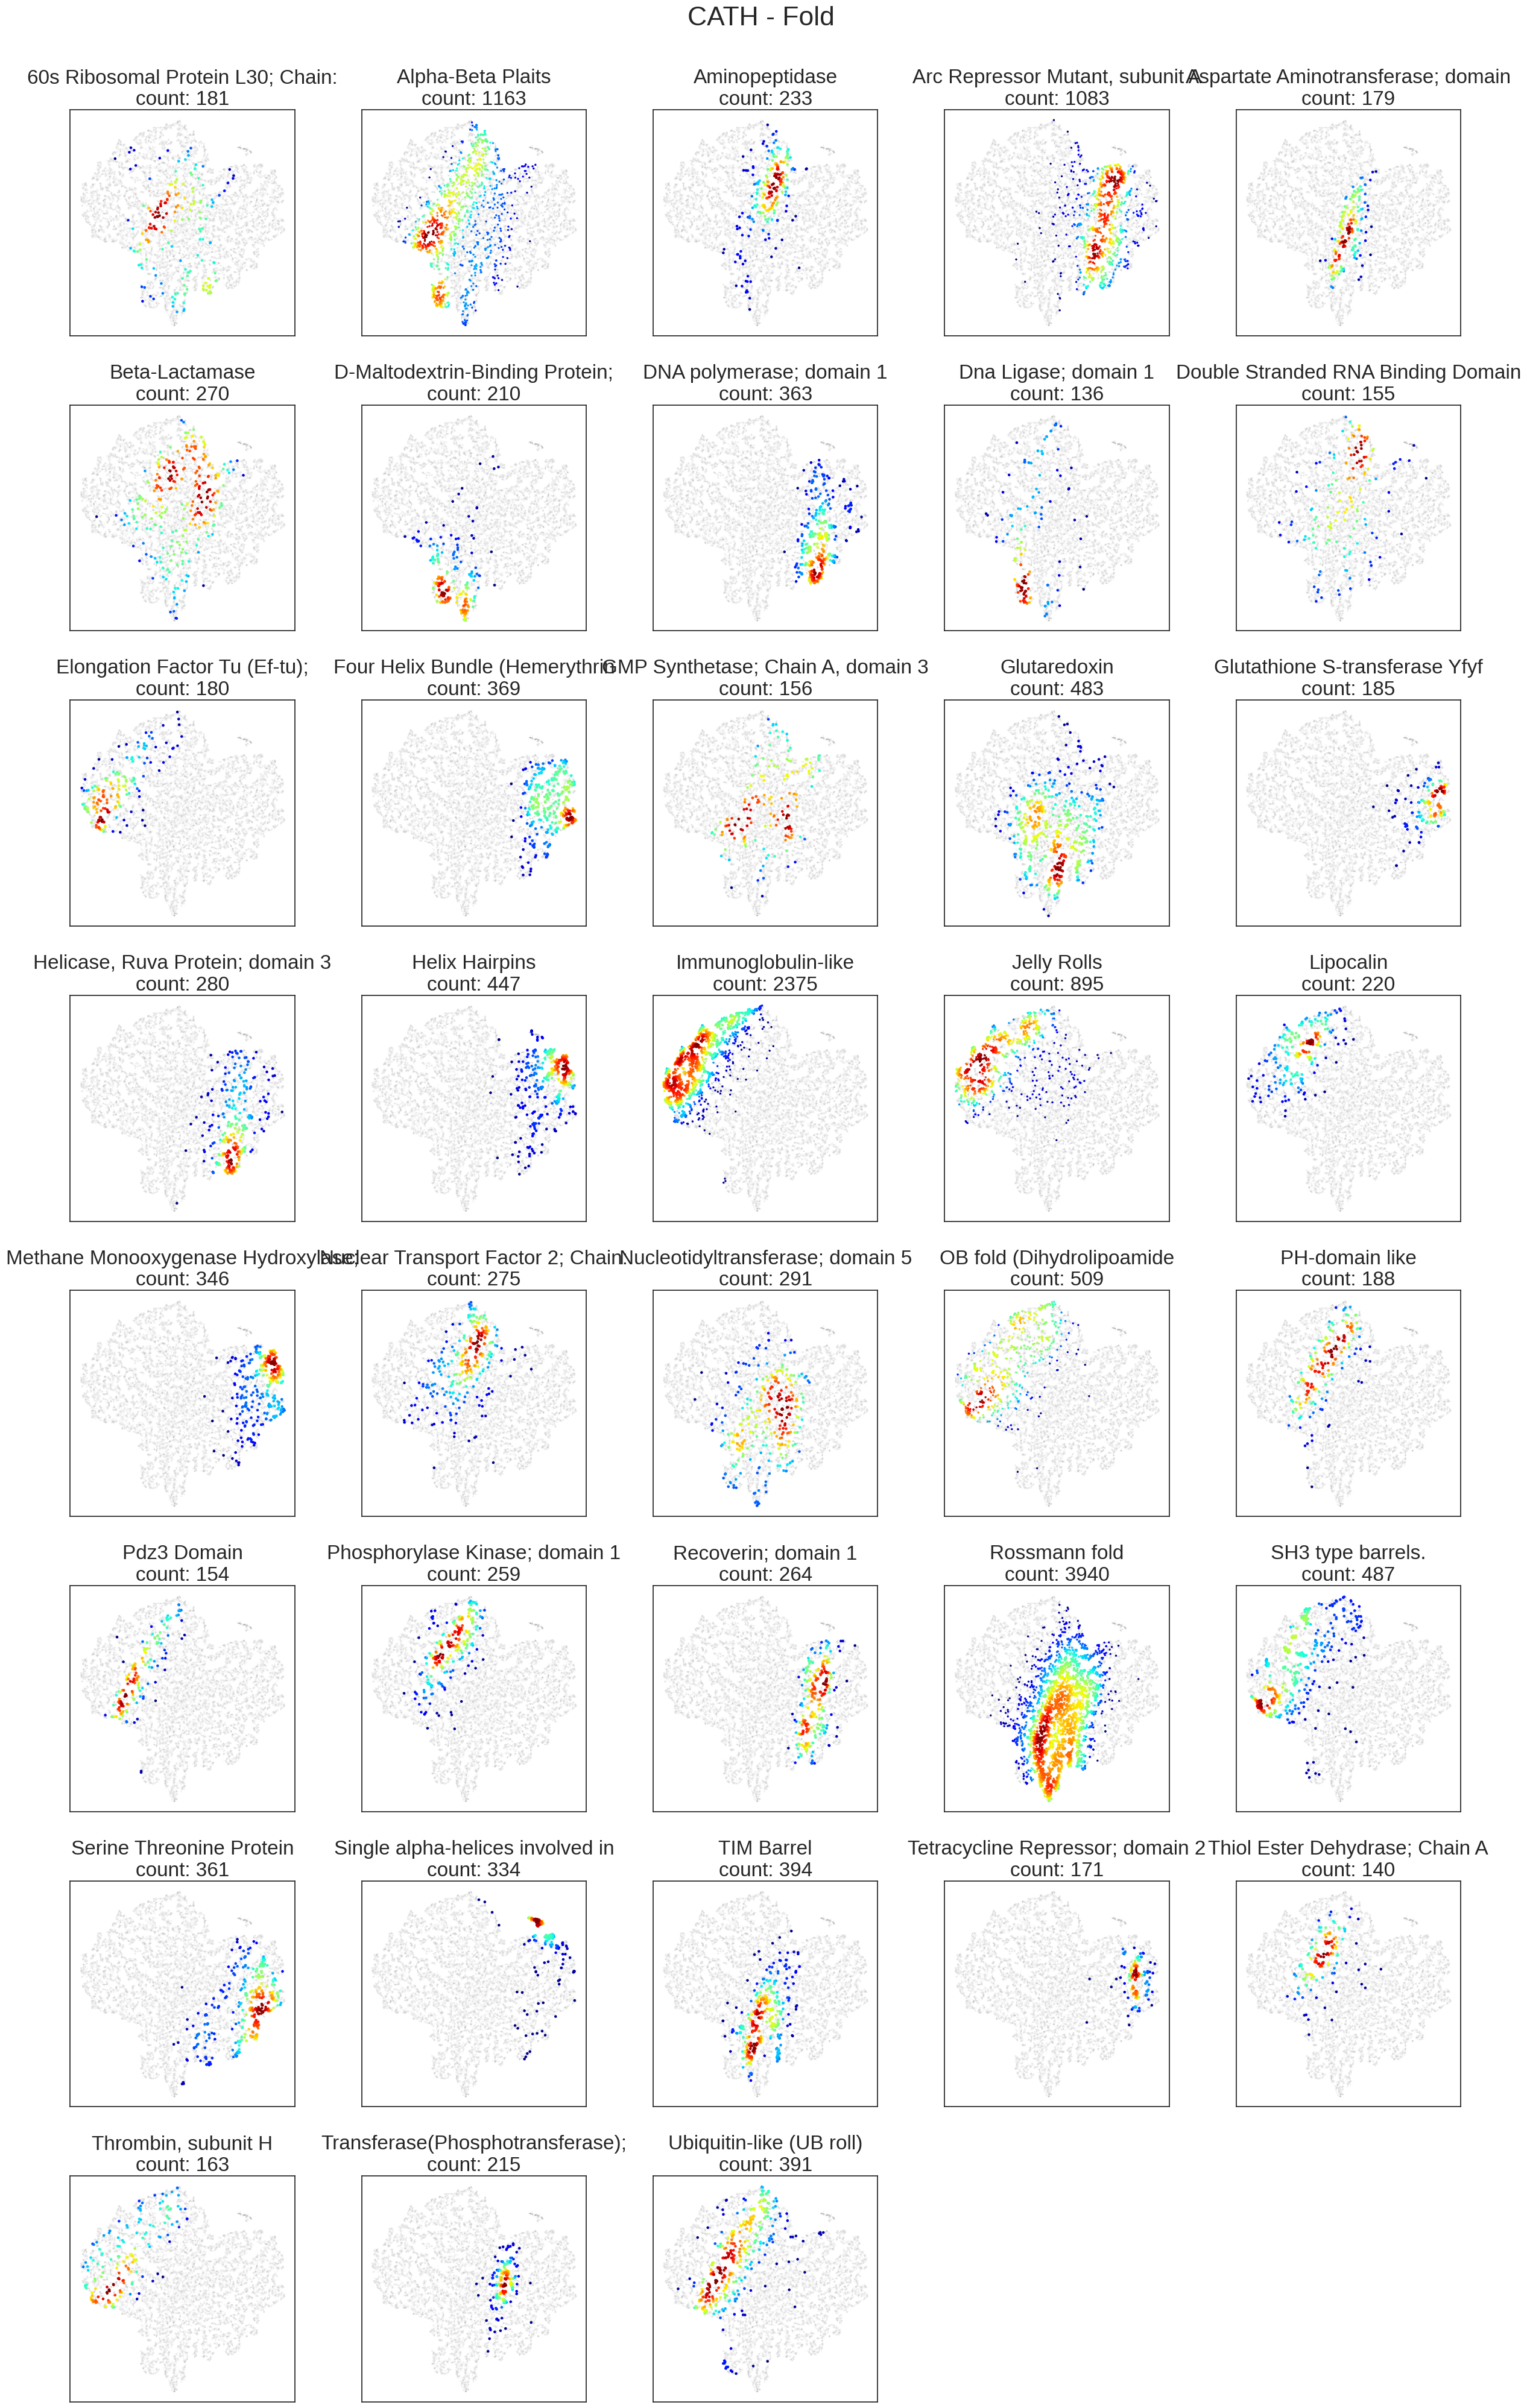

In [13]:
min_num = 130

archi_ctr = Counter(label_index)
valid_archi = [archi for archi, num in archi_ctr.most_common() if num >= min_num]
valid_archi = sorted(valid_archi)
n_architecture = len(valid_archi)

n_col = 5
n_row = int(np.ceil(n_architecture / n_col))

fig, ax = plt.subplots(n_row, n_col, figsize=(n_col * 5, n_row * 5), subplot_kw={'aspect': 1})
fig.tight_layout(pad=6.0)

ft = 15
ft_l = 24
ft_ll = 32

fig.suptitle(attrib_label, fontsize=ft_ll, y=1.02)

for i, archi_idx in enumerate(valid_archi):
    positive_mask = label_index == archi_idx

    ax[i // n_col][i % n_col].scatter(embed_2d[~positive_mask, 0], embed_2d[~positive_mask, 1], s=1, color='grey', alpha=0.02)

    xy = embed_2d[positive_mask, :]
    # https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density
    xy_T = xy.T
    z = gaussian_kde(xy_T)(xy_T)
    idx = z.argsort()
    x, y, z = xy[idx, 0], xy[idx, 1], z[idx]
    # increase the size when total number of points is small
    if len(x) < 100:
        size = 10
    elif len(x) < 500:
        size = 5
    else:
        size = 2
    ax[i // n_col][i % n_col].scatter(x, y, c=z, s=size, cmap='jet')

    ax[i // n_col][i % n_col].tick_params(axis='both', which='major', labelsize=ft)
    ax[i // n_col][i % n_col].set_title('%s\ncount: %d' % (max_complete_word(class_text[archi_idx], 35), archi_ctr[archi_idx]),
                                                        fontsize=ft_l)


    ax[i // n_col][i % n_col].set_xticks([])
    ax[i // n_col][i % n_col].set_yticks([])

# blank for padding
for i in range(n_architecture, n_col * n_row):
    ax[i // n_col][i % n_col].axis('off')

# CATH - proportion of alpha helix

In [14]:
attrib = label_df['alpha_ratio']
attrib_label = 'CATH - Proportion of alpha helix'
attrib_legend_title = 'Ratio'

Text(0.5, 1.0, 'CATH - Proportion of alpha helix')

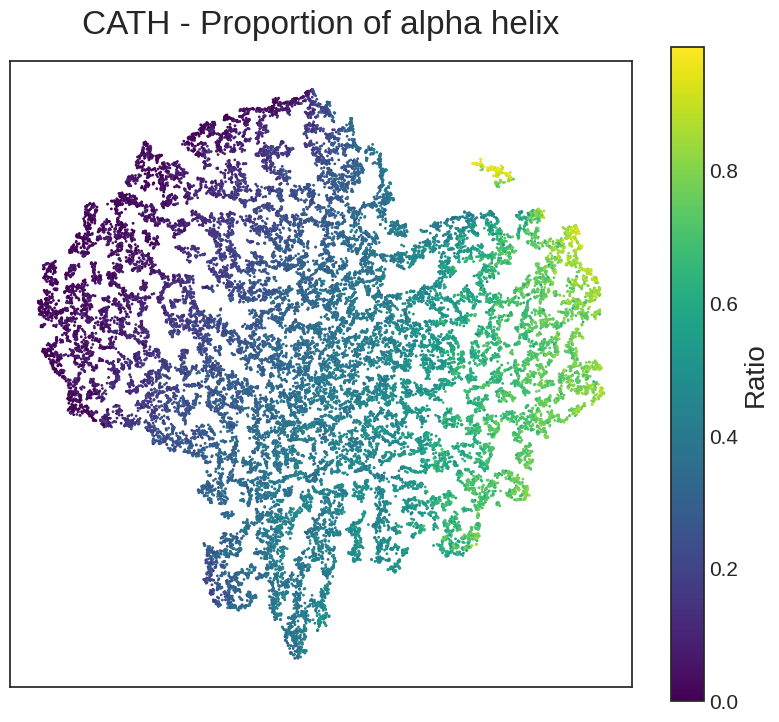

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9), subplot_kw={'aspect': 1}, squeeze=False)
fig.tight_layout(pad=8.0)

ft = 15
ft_l = 20
ft_ll = 24

scatter = ax[0, 0].scatter(embed_2d[:, 0], embed_2d[:, 1], s=1, c = attrib, cmap='viridis')
cbar = plt.colorbar(scatter, ax=ax[0, 0])
ax[0, 0].tick_params(axis='both', which='major', labelsize=ft)
cbar.ax.tick_params(labelsize=ft)
cbar.set_label(attrib_legend_title, fontsize=ft_l)

# remove ticks
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 0].set_title(attrib_label, fontsize=ft_ll, pad=20)

# CATH - proportion of beta sheet

In [16]:
attrib = label_df['beta_ratio']
attrib_label = 'CATH - Proportion of beta sheet'
attrib_legend_title = 'Ratio'

Text(0.5, 1.0, 'CATH - Proportion of beta sheet')

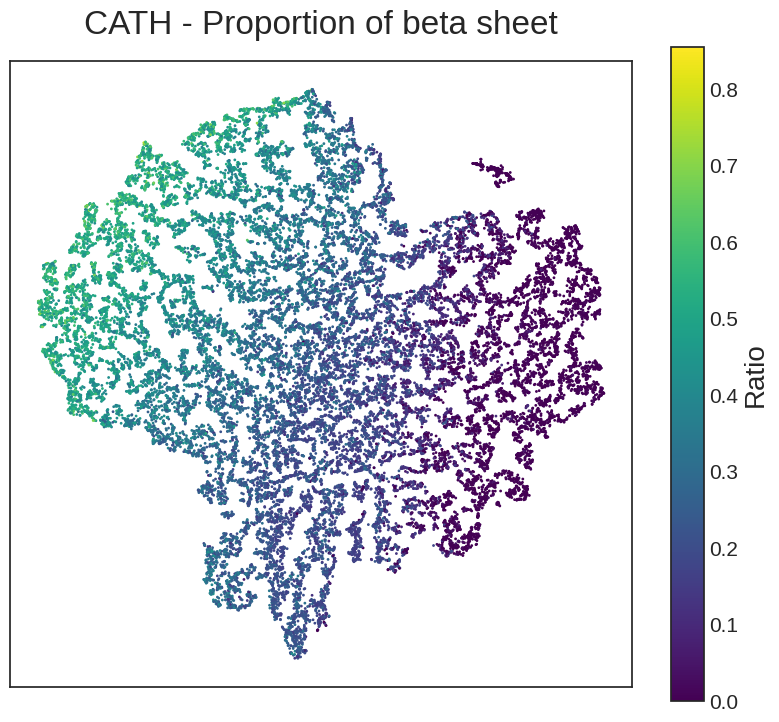

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9), subplot_kw={'aspect': 1}, squeeze=False)
fig.tight_layout(pad=8.0)

ft = 15
ft_l = 20
ft_ll = 24

scatter = ax[0, 0].scatter(embed_2d[:, 0], embed_2d[:, 1], s=1, c = attrib, cmap='viridis')
cbar = plt.colorbar(scatter, ax=ax[0, 0])
ax[0, 0].tick_params(axis='both', which='major', labelsize=ft)
cbar.ax.tick_params(labelsize=ft)
cbar.set_label(attrib_legend_title, fontsize=ft_l)

# remove ticks
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 0].set_title(attrib_label, fontsize=ft_ll, pad=20)

# CATH - proportion of coil

In [18]:
attrib = label_df['coil_ratio']
attrib_label = 'CATH - Proportion of coil'
attrib_legend_title = 'Ratio'

Text(0.5, 1.0, 'CATH - Proportion of coil')

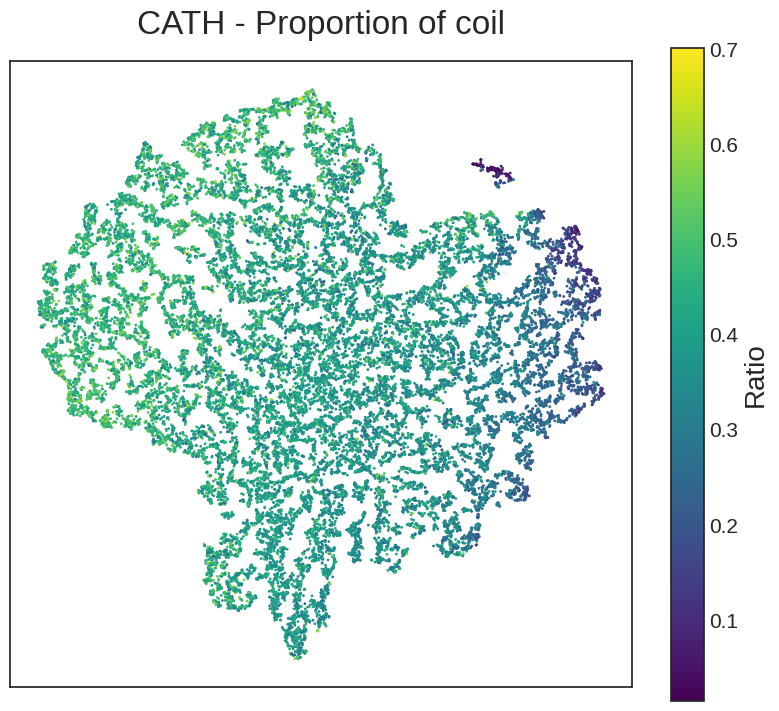

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9), subplot_kw={'aspect': 1}, squeeze=False)
fig.tight_layout(pad=8.0)

ft = 15
ft_l = 20
ft_ll = 24

scatter = ax[0, 0].scatter(embed_2d[:, 0], embed_2d[:, 1], s=1, c = attrib, cmap='viridis')
cbar = plt.colorbar(scatter, ax=ax[0, 0])
ax[0, 0].tick_params(axis='both', which='major', labelsize=ft)
cbar.ax.tick_params(labelsize=ft)
cbar.set_label(attrib_legend_title, fontsize=ft_l)

# remove ticks
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 0].set_title(attrib_label, fontsize=ft_ll, pad=20)

# CATH - gyration radius

In [20]:
attrib = label_df['gyration_radius']
attrib_label = 'CATH - Gyration radius'
attrib_legend_title = r'Radius($nm$)'

Text(0.5, 1.0, 'CATH - Gyration radius')

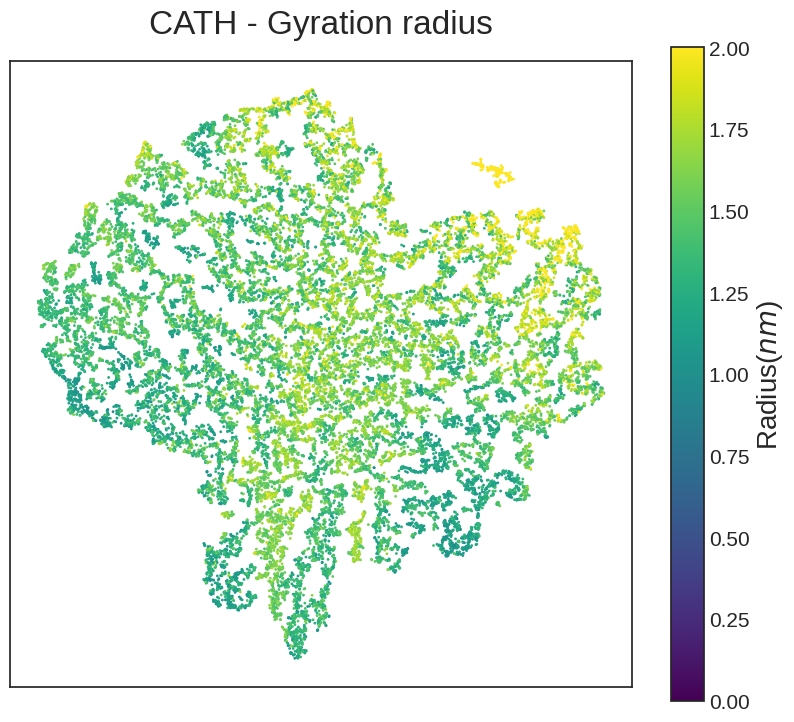

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9), subplot_kw={'aspect': 1}, squeeze=False)
fig.tight_layout(pad=8.0)

ft = 15
ft_l = 20
ft_ll = 24

scatter = ax[0, 0].scatter(embed_2d[:, 0], embed_2d[:, 1], s=1, c = attrib, cmap='viridis', vmin=0, vmax=2)
cbar = plt.colorbar(scatter, ax=ax[0, 0])
ax[0, 0].tick_params(axis='both', which='major', labelsize=ft)
cbar.ax.tick_params(labelsize=ft)
cbar.set_label(attrib_legend_title, fontsize=ft_l)

# remove ticks
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 0].set_title(attrib_label, fontsize=ft_ll, pad=20)

# CATH - Length

In [22]:
attrib = label_df['length']
attrib_label = 'CATH - Length'
attrib_legend_title = 'Length'

Text(0.5, 1.0, 'CATH - Length')

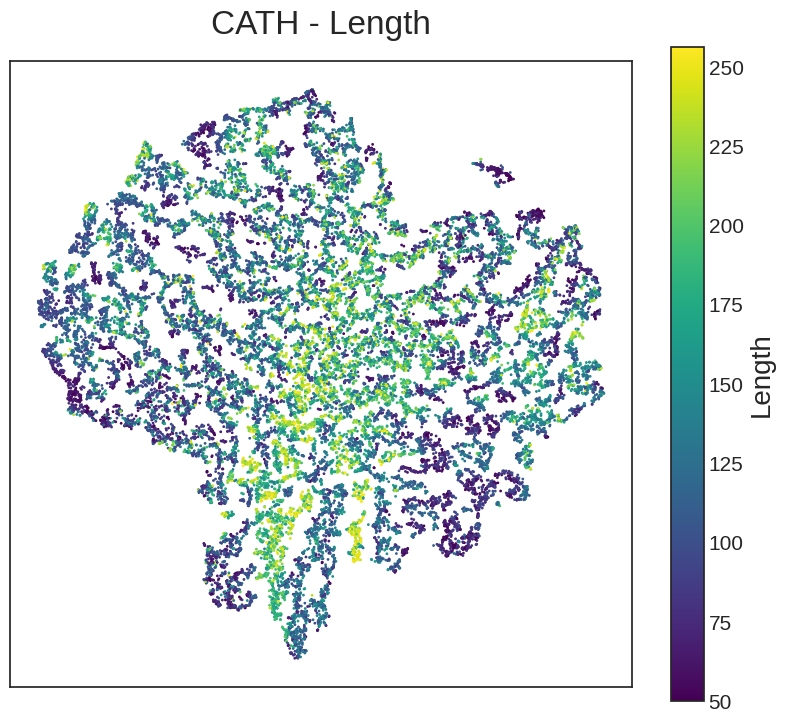

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 9), subplot_kw={'aspect': 1}, squeeze=False)
fig.tight_layout(pad=8.0)

ft = 15
ft_l = 20
ft_ll = 24

scatter = ax[0, 0].scatter(embed_2d[:, 0], embed_2d[:, 1], s=1, c = attrib, cmap='viridis')
cbar = plt.colorbar(scatter, ax=ax[0, 0])
ax[0, 0].tick_params(axis='both', which='major', labelsize=ft)
cbar.ax.tick_params(labelsize=ft)
cbar.set_label(attrib_legend_title, fontsize=ft_l)

# remove ticks
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 0].set_title(attrib_label, fontsize=ft_ll, pad=20)